# Topic entropy in Telegram communities

## Import packages

In [1]:
# !pip install zstandard
# !pip install ujson
# !pip install stopwordsiso
# !pip install matplotlib
# !pip install nltk
# !pip install bs4

In [1]:
# Read data
import pickle
import pandas as pd
import zstandard as zstd
import json
import ujson
import io
import os

# SNA
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import re
from itertools import islice

# Domain study
from collections import Counter
# import urlexpander

import random
random.seed(2024)

In [2]:
# Error solving
np.float = float
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'
np. typeDict = np.sctypeDict

# NLP
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
import string
import stopwordsiso as stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\167266\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\167266\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\167266\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
#importing the libraries
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry


session = requests.Session()
retry = Retry(connect=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

## Text pre-processing

In [5]:
# Messages

msg_df = pd.read_csv("E:\._PhD\Publications\SocSem_Telegram\data\msg_df_with_urls.csv")

print("Total number of messages, including duplicates:", len(msg_df))

Total number of messages, including duplicates: 2669449


In [6]:
# Filter on alt-tech domains

# List of alt-tech platforms from Wikipedia (https://en.wikipedia.org/wiki/Alt-tech#List_of_alt-tech_platforms)
# # Excluding mainstream social media platforms and inactive platforms we couldn't trace a URL for
alt = {"Gab": "gab.com",
"Gettr" : "gettr.com",
"Parler" : "parler.com",
"Truth Social" : "truthsocial.com",
"BitChute" : "bitchute.com",
"DLive" : "dlive.tv",
"DTube" : "d.tube",
"Odysee" : "lbry.com",
"PewTube" : "pewtube.com",
"Rumble" : "rumble.com",
"Triller" : "triller.co",
"GiveSendGo" : "givesendgo.com",
"Hatreon" : "hatreon.net",
"SubscribeStar" : "subscribestar.com",
"GoyFundMe" : "goyfundme.com",
"MeWe" : "mewe.com",
"Minds" : "minds.com",
"Thinkspot" : "thinkspot.com",
"Patriots.win" : "patriots.win",
"Infogalactic" : "infogalactic.com",
"Metapedia" : "metapedia.org",
"8kun" : "8kun.top",
"WASP Love" : "wasplove.com",
"JustPaste.it" : "justpaste.it",
"Epik" : "epik.com"}


In [14]:
import ast

# all_urls = [url for sublist in [x for x in msg_df.url] for url in ast.literal_eval(sublist)]
len(all_urls)

2675328

In [19]:
alt_urls = [u for u in all_urls if u.replace('www.', '') in alt.values()]
len(alt_urls)

3238

In [17]:
set(alt_urls)

{'bitchute.com',
 'd.tube',
 'dlive.tv',
 'gab.com',
 'hatreon.net',
 'justpaste.it',
 'lbry.com',
 'mewe.com',
 'minds.com',
 'parler.com',
 'pewtube.com',
 'subscribestar.com',
 'www.bitchute.com',
 'www.epik.com',
 'www.minds.com',
 'www.subscribestar.com'}

In [20]:
# Filter the DataFrame m to create alt_df
alt_df = msg_df[msg_df['url'].apply(lambda x: any(url in set(alt_urls) for url in x))]
print(len(alt_df), len(alt_df.message.unique()))

0 0


In [167]:
alt_df.text

33          Зверніть увагу на цей список і змініть хоча б ...
34          Ну і сайти типу Лайвлік, які значно кращі ща ю...
35                                     Alternatives to Google
36                                                 (for news)
37                                   Alternatives for Twitter
                                  ...                        
17931228                                      ✔️ پی‌نوشت مهم:
17931229    ویدئوی فوق در ساعت ۱۷:۲۸:۲۷ دوازدهم نوامبر ۲۰۱...
17931230    زلزله در ساعت ۱۸:۱۸ دوازدهم نوامبر به وقت UTC ...
17931231    احتمال دارد تکنولوژی وجود داشته باشد که بتواند...
17931232                                    @abdollahshahbazi
Name: text, Length: 6920, dtype: object

In [168]:
# Exclude shorter sentences that don't contribute to information
alt_df = alt_df[alt_df['text'].apply(lambda x: len(word_tokenize(str(x))) > 5)]
alt_df.reset_index(drop=True, inplace=True)

print("Total number of sentences after cleaning:", len(alt_df['text'].unique()))


Total number of sentences after cleaning: 1460


In [21]:
# alt_df.to_excel('E:\\._PhD\\Publications\\SocSem_Telegram\\Code\\alt_df.xlsx')
alt_df = pd.read_excel("E:\\._PhD\\Publications\\SocSem_Telegram\\Code\\alt_df.xlsx")

In [22]:
text = list(alt_df['text'].unique())

In [23]:
len(text)

1460

# Sentence-based topic modeling

## Pre-processing

## Modeling

In [24]:
# Embeddings

# !pip install sentence_transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')
embeddings = model.encode(text, show_progress_bar=True)

c:\Users\167266\nlp\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Batches:   0%|          | 0/46 [00:00<?, ?it/s]

In [176]:
# !pip install --force-reinstall -v numpy==1.24
import numpy as np
print(np.__version__)


1.24.0


In [25]:
# Dimensionality reduction

# !pip install umap-learn
import umap.umap_ as umap

umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            metric='cosine').fit_transform(embeddings)

In [26]:
# Clustering

# !pip install hdbscan
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',
                          cluster_selection_method='eom', core_dist_n_jobs=1).fit(umap_embeddings)

cluster_labels = cluster.fit_predict(umap_embeddings)

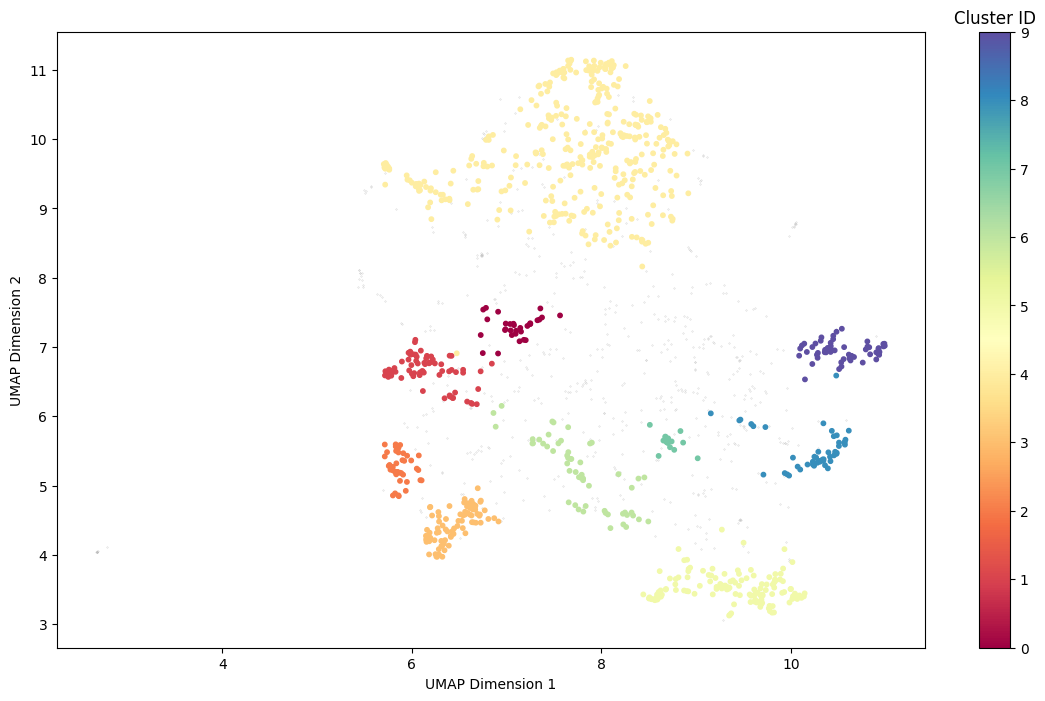

In [27]:
# prompt: Improve the plot produced in the cell above by making it prettier, easy to read, add title to the axes but not the overall plot

import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(14, 8))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap='Spectral')
plt.colorbar().ax.set_title('Cluster ID')
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
plt.show()


In [28]:
# Export topics to Excel

# Group sentences by topic (cluster label)
topics = {}
for sentence, label in zip(text, cluster_labels):
    if label not in topics:
        topics[label] = []
    topics[label].append(sentence)

# Prepare the data for exporting
# Convert each topic to a DataFrame
dataframes = {}
for topic_id, sentences in topics.items():
    df = pd.DataFrame(sentences, columns=['Sentences'])
    dataframes[f'Topic {topic_id}'] = df

len(topics[-1])/len(text)

0.38835616438356163

In [32]:
topics.keys()

dict_keys([4, -1, 1, 0, 5, 8, 2, 6, 3, 9, 7])

In [29]:
# prompt: export all the objects i will need to recreate this exact same plot in the future without running the topic modeling again

import pickle

# Save the necessary objects
objects_to_save = {
    'umap_data': umap_data,
    'cluster_labels': cluster_labels
}

with open('E:\\._PhD\\Publications\\SocSem_Telegram\\data\\topic_modeling_results.pkl', 'wb') as f:
    pickle.dump(objects_to_save, f)


In [33]:
# Print the DataFrames to check the output
for topic_name, df in dataframes.items():
    print(f"\n{topic_name}:")
    print(df)

# Create an Excel writer object
with pd.ExcelWriter('E:\\._PhD\\Publications\\SocSem_Telegram\\data\\topics.xlsx', engine='openpyxl') as writer:
    for topic_name, df in dataframes.items():
        df.to_excel(writer, sheet_name=topic_name, index=False)


Topic 4:
                                             Sentences
0    Зверніть увагу на цей список і змініть хоча б ...
1    Ну і сайти типу Лайвлік, які значно кращі ща ю...
2     🚩 Banned YouTube Accounts BitChute Backup List 🚩
3    ❗️Free free to post other channels in the chat...
4                     Uploaded this for more exposure.
..                                                 ...
356  The main knotting point and focus of vargs onl...
357  This is one example of a video YouTube just ba...
358  Please consider supporting my work on Subscrib...
359  Great to see this up on Bitchute where it belo...
360                        و نیز بنگرید به این وبسایت:

[361 rows x 1 columns]

Topic -1:
                                             Sentences
0                                  * Way of the World:
1                          * Myth of the 20th Century:
2    This is a song dedicated to mike enoch, the je...
3    Josh, the owner of KiwiFarms, will be joining ...
4    Look at them st

## Read previous results

In [71]:
with open('topic_modeling_results.pkl', 'rb') as f:
    topic_modeling_results = pickle.load(f)

umap_data = topic_modeling_results['umap_data']
cluster_labels = topic_modeling_results['cluster_labels']

In [16]:
# # prompt: Read each sheet from topics.xlsx, turn them into lists of strings and compile them into a dictionary

# import re

# def read_excel_sheets_to_dict(filename):
#   """
#   Reads each sheet from an Excel file and compiles them into a dictionary.

#   Args:
#     filename: The path to the Excel file.

#   Returns:
#     A dictionary where keys are sheet names and values are pandas DataFrames.
#   """
#   excel_file = pd.ExcelFile(filename)
#   sheets = {}
#   for sheet_name in excel_file.sheet_names:
#     sheets[int(re.findall(r'\d+', sheet_name)[0])] = excel_file.parse(sheet_name)
#     sheets[int(re.findall(r'\d+', sheet_name)[0])] = sheets[int(re.findall(r'\d+', sheet_name)[0])]['Sentences'].tolist()
#   return sheets

# # Example usage:
# topics = read_excel_sheets_to_dict('topics.xlsx')
